In [1]:
import numpy as np
import pandas as pd
import locale
load = pd.read_csv(r'Load/Load_history.csv', thousands=',')
tem = pd.read_csv(r'Load/temperature_history.csv',thousands=',')

## 构造数据

In [20]:
load = load[(load.month ==1) & (load.year == 2004)].dropna()
tem = tem[(tem.month ==1) & (tem.year == 2004)].dropna()

power = np.array(load.iloc[:,4:4+24]).reshape(-1,1)
temprature = np.array(tem.iloc[:,4:4+24]).reshape(-1,1)
hour = np.arange(1,25).reshape(-1,1)
hours = np.tile(hour,(len(tem),1))

## 获得weeks
week = np.arange(1,8).reshape(-1,1)
weeks = np.tile(week,(1,24))
weeks = np.tile(weeks,(3,1))
weeks.reshape(-1,).shape
def get_week(week):
    week = np.array(week).reshape(-1,1)
    weeks = np.tile(week,(1,24))
    return weeks.ravel()

weeks = np.append(weeks,get_week([1,2,3,4,5,6]))
weeks = np.insert(weeks,0,get_week([4,5,6,7])).reshape(-1,1)

data = np.concatenate((weeks,hours,temprature,power),axis=1)
X = data
Y = data[:,-1].reshape(-1,1)

print("X.shape",X.shape)
print("Y.shape",Y.shape)

X.shape (744, 4)
Y.shape (744, 1)


## 获得用于训练模型的数据集
### 单步预测

In [21]:
def cpv(X,Y,delay,p):
    n = X.shape[0] 
    w = X.shape[1] 
    X_train = np.zeros((n-delay-p,w + delay + 1))
    X_train[:,:w] = X[delay:-p,:]
    for i in range(delay+1):
        X_train[:,w+i] = Y[delay-i:-p-i].reshape(-1,)

    Y_train = np.zeros((n-delay-p, p))
    for i in range(p):
        Y_train[:,i] = Y[delay+1+i:n-p+1+i].reshape(-1,)
    return X_train, Y_train


X, Y = cpv(np.array(X[:,:-1]), np.array(Y), delay=0, p=1)
print(f'X.shape: {X.shape}, Y.shape:{Y.shape}')

X.shape: (743, 4), Y.shape:(743, 1)


## 划分训练集和测试集
## 归一化

In [78]:
def split(X, Y, test_size=0.25):
    test_n = 24*6
    
    X_train = X[:X.shape[0]-test_n,:]
    y_train = Y[:Y.shape[0]-test_n,:]
    
    X_test = X[-test_n:,:]
    y_test = Y[-test_n:,:]
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = split(X, Y, test_size=0.25)
print('X_train', X_train.shape)
print('X_test', X_test.shape)
max_train = X_train.max(0)
min_train = X_train.min(0)
max_y = y_train.max(0)
min_y = y_train.min(0)
mean_y = y_train.mean(0)

X_train = (X_train - min_train)/(max_train - min_train)
X_test = (X_test - min_train)/(max_train - min_train)
y_train = (y_train - min_y)/(max_y - min_y)
y_test = (y_test - min_y)/(max_y - min_y)


X_train (599, 4)
X_test (144, 4)


## 高斯分位数回归

In [118]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern
import time

def mae(y_true, y_pred): 
    N_metric =  np.fabs(y_true - y_pred)
    metric = N_metric.mean(0)
    return metric

def mape(yt,yp):
    mask = yt != 0.0
    return np.fabs((yp[mask] - yt[mask])/ yt[mask]).mean(0)

# 区间评价指标 取 a = 0.95
def PIs(y_test_pred_m, y_test_pred_s, y_test):
    U = y_test_pred_m.reshape(-1,) + 1.96*y_test_pred_s
    L = y_test_pred_m.reshape(-1,) - 1.96*y_test_pred_s
    PICP = sum((y_test.reshape(-1,) <= U) & (y_test.reshape(-1,) >= L))/len(U)
    PINAW = sum(U-L)/(len(U)*( y_test.max()-y_test.min()))
    r = float(PICP <= 0.95)
    eta = 1
    CWC = PINAW*(1+r*np.exp(-eta*(PICP - 0.95)))
    print('PICP:',PICP,'\tPINAW:',PINAW,'\tCWC:',CWC)

kernel = 1.0 * RBF(length_scale=15) + WhiteKernel(1e-1) 

gaussian_process = GaussianProcessRegressor(kernel=kernel)
start_time = time.time()
gaussian_process.fit(X_train, y_train)
print(
    f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds"
)

print(gaussian_process.kernel_)
y_test_pred_m, y_test_pred_s = gaussian_process.predict(X_test, return_std=True)

print('mae: %.3f'%(mae(y_test, y_test_pred_m)*(max_y - min_y)))
print('mape: %.3f'%(mape(y_test, y_test_pred_m)))
PIs(y_test_pred_m, y_test_pred_s, y_test)

Time for GaussianProcessRegressor fitting: 1.061 seconds
4.32**2 * RBF(length_scale=11.3) + WhiteKernel(noise_level=0.0025)
mae: 1029.641
mape: 0.066
PICP: 0.9861111111111112 	PINAW: 0.27499410476073766 	CWC: 0.27499410476073766


0.9861111111111112 0.27499410476073766 0.27499410476073766


In [116]:
kernel = 1.0 * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e2)) + WhiteKernel(1e-1)
gaussian_process = GaussianProcessRegressor(kernel=kernel)
start_time = time.time()
gaussian_process.fit(X_train, y_train)
print(
    f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds"
)

print(gaussian_process.kernel_)
y_test_pred_m, y_test_pred_s = gaussian_process.predict(X_test, return_std=True)

print('mae: %.3f'%(mae(y_test, y_test_pred_m)*(max_y - min_y)))
print('mape: %.3f'%(mape(y_test, y_test_pred_m)))
PIs(y_test_pred_m, y_test_pred_s, y_test)

Time for GaussianProcessRegressor fitting: 0.641 seconds
0.343**2 * ExpSineSquared(length_scale=6.28, periodicity=5.59) + WhiteKernel(noise_level=0.0051)
mae: 1368.660
mape: 0.083
PICP: 1.0 	PINAW: 0.392115914401462 	CWC: 0.392115914401462


In [117]:
kernel = 1.0 * Matern(length_scale=1.0,length_scale_bounds=(1e-2, 1e1), nu=1) + WhiteKernel(1e-1)
gaussian_process = GaussianProcessRegressor(kernel=kernel)
start_time = time.time()
gaussian_process.fit(X_train, y_train)
print(
    f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds"
)
print(gaussian_process.kernel_)
y_test_pred_m, y_test_pred_s = gaussian_process.predict(X_test, return_std=True)

print('mae: %.3f'%(mae(y_test, y_test_pred_m)*(max_y - min_y)))
print('mape: %.3f'%(mape(y_test, y_test_pred_m)))
PIs(y_test_pred_m, y_test_pred_s, y_test)

Time for GaussianProcessRegressor fitting: 8.036 seconds
0.524**2 * Matern(length_scale=1.81, nu=1) + WhiteKernel(noise_level=7.86e-05)
mae: 1230.758
mape: 0.072
PICP: 0.875 	PINAW: 0.2191024780705091 	CWC: 0.45526956660225837


## 评价结果

In [25]:
def mae(y_true, y_pred): 
    N_metric =  np.fabs(y_true - y_pred)
    metric = N_metric.mean(0)
    return metric

def mape(yt,yp):
    mask = yt != 0.0
    return np.fabs((yp[mask] - yt[mask])/ yt[mask]).mean(0)

print('mae: %.3f'%(mae(y_test, y_test_pred_m)*(max_y - min_y)))
print('mape: %.3f'%(mape(y_test, y_test_pred_m)))

mae: 1029.641
mape: 0.066


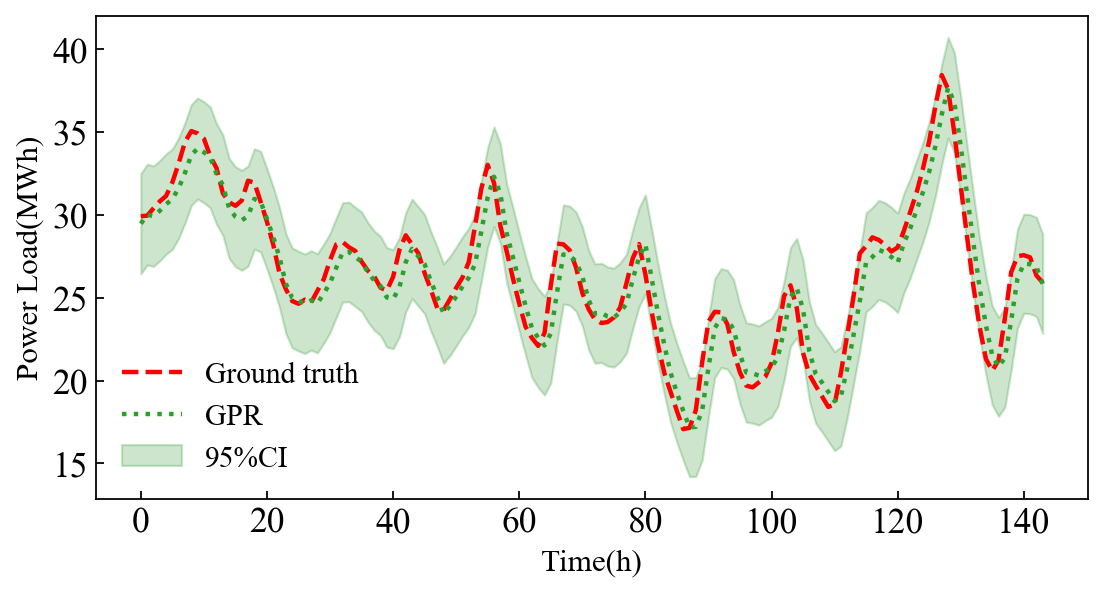

In [149]:
y_max = max_y
y_min = min_y

import matplotlib.pyplot as plt
from matplotlib import rcParams

config = {
"font.family":"times new roman",    
"font.size": 16,
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
}
rcParams.update(config)
plt.figure(dpi=160, figsize=(8,4))
plt.plot((y_test*(y_max-y_min)+y_min)/1000, label="True signal", linewidth=2,color="r", linestyle="dashed")

# Plot the predictions of the gaussian process regressor
plt.plot(
    (y_test_pred_m*(y_max-y_min)+y_min)/1000,
    label="Gaussian process regressor",
    linewidth=2,
    color="tab:green",
    linestyle="dotted",
)
plt.fill_between(
    np.arange(len( y_test_pred_m)),
    ((y_test_pred_m.reshape(-1,) -  2*y_test_pred_s)*(y_max-y_min)+y_min)/1000,
    ((y_test_pred_m.reshape(-1,) +  2*y_test_pred_s)*(y_max-y_min)+y_min)/1000,
    color="green",
    alpha=0.2,
)
plt.xlabel("Time(h)",{"size":14})
plt.ylabel("Power Load(MWh)",{"size":14})
plt.legend(['Ground truth','GPR','95%CI'],frameon=False, fontsize = 'small',loc="lower left")

In [199]:
def Gaussian_Distribution(m=0, sigma=1):
    x = np.linspace(m-4*sigma, m+4*sigma, 200)
    p = 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(x-m)**2/(2*sigma**2))
    return x, p

clock = 0
tr1 = (y_test[clock]*(y_max-y_min)+y_min)/1000
me1 = (y_test_pred_m[clock]*(y_max-y_min)+y_min)/1000
st1 = (y_test_pred_s[clock]*(y_max-y_min))/1000
x1, p1 = Gaussian_Distribution(m=me1, sigma=st1)

clock = 5 
tr2 = (y_test[clock]*(y_max-y_min)+y_min)/1000
me2 = (y_test_pred_m[clock]*(y_max-y_min)+y_min)/1000
st2 = (y_test_pred_s[clock]*(y_max-y_min))/1000
x2, p2 = Gaussian_Distribution(m=me2, sigma=st2)

clock = 11 
tr3 = (y_test[clock]*(y_max-y_min)+y_min)/1000
me3 = (y_test_pred_m[clock]*(y_max-y_min)+y_min)/1000
st3 = (y_test_pred_s[clock]*(y_max-y_min))/1000
x3, p3 = Gaussian_Distribution(m=me3, sigma=st3)

clock = 16
tr4 = (y_test[clock]*(y_max-y_min)+y_min)/1000
me4 = (y_test_pred_m[clock]*(y_max-y_min)+y_min)/1000
st4 = (y_test_pred_s[clock]*(y_max-y_min))/1000
x4, p4 = Gaussian_Distribution(m=me4, sigma=st4)
tr4,me4

(array([30.869]), array([29.67311619]))

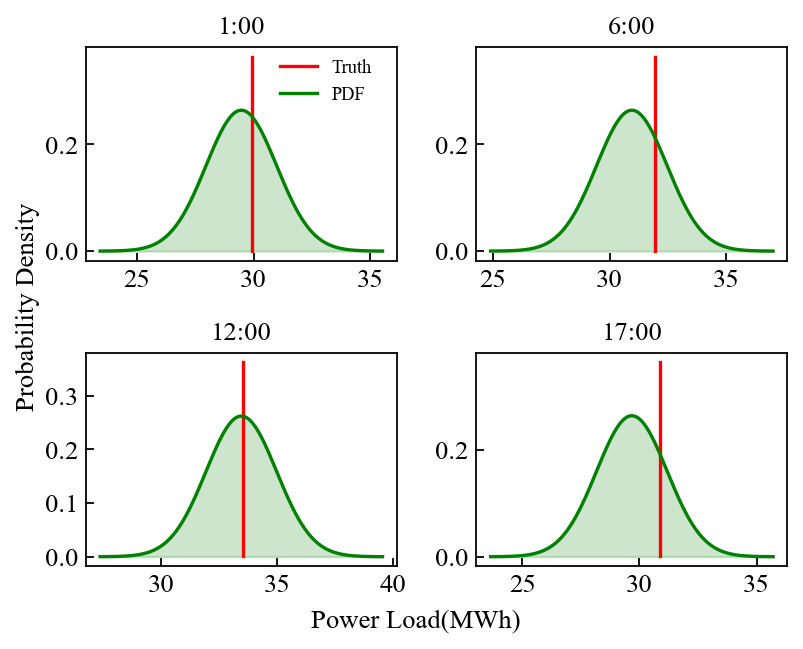

In [200]:
config = {
"font.family":"times new roman",    
"font.size": 12,
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
}
rcParams.update(config)

fig, ax1 = plt.subplots(2,2, figsize=(5,4), dpi=160)

ax1[0,0].plot([tr1, tr1],[0.001, p1.max()+0.1], color="red", linewidth=1.5)
ax1[0,0].plot(x1, p1, color='green',linewidth=1.5)
ax1[0,0].fill_between(x1.reshape(-1,), 0, p1.reshape(-1,), color="green", alpha=0.2)
ax1[0,0].set_title('1:00', size=12)
#ax1[0,0].set_xticks([1,5,10,15,20])
ax1[0,0].legend(['Truth','PDF'],frameon=False, fontsize = 'x-small',loc=(0.6,0.7))


ax1[0,1].plot([tr2, tr2],[0.001, p2.max()+0.1], color="red", linewidth=1.5)
ax1[0,1].plot(x2, p2, color='green',linewidth=1.5)
ax1[0,1].fill_between(x2.reshape(-1,), 0, p2.reshape(-1,), color="green", alpha=0.2)
ax1[0,1].set_title('6:00', size=12)

ax1[1,0].plot([tr3, tr3],[0.001, p3.max()+0.1], color="red", linewidth=1.5)
ax1[1,0].plot(x3, p3, color='green',linewidth=1.5)
ax1[1,0].fill_between(x3.reshape(-1,), 0, p3.reshape(-1,), color="green", alpha=0.2)
ax1[1,0].set_title('12:00', size=12)

ax1[1,1].plot([tr4, tr4],[0.001, p4.max()+0.1], color="red", linewidth=1.5)
ax1[1,1].plot(x4, p4, color='green',linewidth=1.5)
ax1[1,1].fill_between(x4.reshape(-1,), 0, p4.reshape(-1,), color="green", alpha=0.2)
ax1[1,1].set_title('17:00', size=12)

fig.text(0.5, 0, "Power Load(MWh)",size=12, ha='center')
fig.text(0, 0.5, "Probability Density",size=12, va='center', rotation='vertical')   
plt.tight_layout()

In [ ]:
point = 100
ax1[0,1].plot(x,(500+200*y_test[point:point+horizon]),'r',linewidth=2.0)
ax1[0,1].plot(x,(500+200*y_pred[point,:]),linewidth=2.0)
ax1[0,1].plot(x,500+200*Tem_test[point:point+horizon],alpha=0.7,linewidth=2.0)
ax1[0,1].set_title('No.100', size=12)
ax1[0,1].set_xticks([1,5,10,15,20])

point = 150
ax1[1,0].plot(x,(500+200*y_test[point:point+horizon]),'r',linewidth=2.0)
ax1[1,0].plot(x,(500+200*y_pred[point,:]),linewidth=2.0)
ax1[1,0].plot(x,500+200*Tem_test[point:point+horizon],alpha=0.7,linewidth=2.0)
ax1[1,0].set_title('No.150', size=12)
ax1[1,0].set_xticks([1,5,10,15,20])

point = 200
ax1[1,1].plot(x,(500+200*y_test[point:point+horizon]),'r',linewidth=2.0)
ax1[1,1].plot(x,(500+200*y_pred[point,:]),linewidth=2.0)
ax1[1,1].plot(x,500+200*Tem_test[point:point+horizon],alpha=0.7,linewidth=2.0)
ax1[1,1].set_title('No.200', size=12)
ax1[1,1].set_xticks([1,5,10,15,20])
